In [1]:
import os, argparse, glob
import pandas as pd
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
# from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
# from datasets import Dataset
# from peft import PeftModel, prepare_model_for_kbit_training
from IPython.display import display, Latex # Used for displaying formatted text in notebooks
from sklearn.model_selection import StratifiedKFold

import shutil
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [24]:
TRAIN_CSV = "./raw_data/train.csv"
USE_SINGLE_FOLD = True

MODEL_NAME = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
MODEL_DIR = "./dpq8b_lora"

CLEAN_MISLABEL = "ignore"
CV_FOLD = 5
CV_SEED = 42

In [31]:
def clean_mislabel_entries(train: pd.DataFrame) -> pd.DataFrame:
    print(f"Using {CLEAN_MISLABEL} for data cleaning Strat")
    qid = 31778
    correct_answer = r"\( 6 \)"
    rows_to_fix = []
    for idx, row in train[train['QuestionId'] == qid].iterrows():
        is_correct_answer = row['MC_Answer'] == correct_answer
        is_true = str(row['Category']).startswith("True")
        if is_correct_answer and not is_true:
            rows_to_fix.append(idx)
        elif not is_correct_answer and is_true:
            rows_to_fix.append(idx)
    assert len(rows_to_fix) == 18, "Expected 18 mislabeled entries to fix, found a different number."

    if CLEAN_MISLABEL == "ignore":
        return train
    elif CLEAN_MISLABEL == "remove":
        return train.drop(index=rows_to_fix).reset_index(drop=True)
    elif CLEAN_MISLABEL == "fix":
        for idx in rows_to_fix:
            row = train.loc[idx]
            cat = str(row['Category']).split("_", 1)[-1]
            prefix = "True" if row['MC_Answer'] == correct_answer else "False"
            train.at[idx, 'Category'] = f"{prefix}_{cat}"
        return train
    else:
        raise ValueError("CLEAN_MISLABEL must be 'ignore', 'remove', or 'fix'")

def load_and_preprocess_data():
    train = pd.read_csv(TRAIN_CSV)
    train = clean_mislabel_entries(train)
    train['Misconception'] = train['Misconception'].fillna('NA')
    # Store full label for evaluation
    train['full_target'] = train['Category'] + ":" + train['Misconception']
    
    # Train only on suffix (remove True_/False_)
    train['misconception_target'] = (
        train['Category'].str.split("_", n=1).str[-1] + ":" + train['Misconception']
    )

    le = LabelEncoder()
    train['label'] = le.fit_transform(train['misconception_target'])

    if "is_correct" in train.columns:
        train = train.drop(columns = "is_correct")
    
    idx = train['Category'].str.startswith("True")
    correct = (
        train[idx].groupby(['QuestionId','MC_Answer']).size()
        .reset_index(name='c').sort_values('c', ascending=False)
        .drop_duplicates(['QuestionId']).assign(is_correct=1)[['QuestionId','MC_Answer','is_correct']]
    )

    train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
    train['is_correct'] = train['is_correct'].fillna(0)

    # suppose you also have a QuestionId -> CorrectAnswerText mapping
    answers = train.loc[train["is_correct"] == 1, ["QuestionId", "MC_Answer"]].rename(
        columns={"MC_Answer": "TrueAnswer"}
    ).drop_duplicates(['QuestionId'], keep="first")
    
    train = train.merge(answers, on="QuestionId", how="left")

    train["split_key"] = (train['QuestionId'].astype(str) + "_" + train['label'].astype(str)).astype('category').cat.codes
    return train, le

In [39]:

def run_model_less_classes(model_dir, model_name, fold_idx, val_df, max_len=256, use_bitsandbytes=False):
    DIR = model_dir
    MODEL_NAME = model_name
    FOLD_IDX = fold_idx

    MAX_LEN = max_len
    use_bitsandbytes = use_bitsandbytes
    
    # --- Format Input ---
    def format_input(row):
        x = "Yes"
        if not row['is_correct']:
            x = "No"
        # maybe prompt: Check for any misconception student might have
        return (
            f"Question: {row['QuestionText']}\n"
            f"Student Answer: {row['MC_Answer']}\n"
            f"Correct? {x}\n"
            f"Student Explanation: {row['StudentExplanation']}\n"
        )
    
    # --- Prepare Dataset ---
    def prepare_dataset(df, tokenizer, cols=['text', 'label']):
        df = df[cols].copy().reset_index(drop=True)
        df['label'] = df['label'].astype(np.int64)
        ds = Dataset.from_pandas(df, preserve_index=False)
        ds = ds.map(lambda batch: tokenizer(batch['text'], padding="max_length", truncation=True, max_length=MAX_LEN), batched=True, remove_columns=['text'])
        return ds
    
    # --- Compute MAP@3 ---
    def compute_map3(eval_pred):
        logits, labels = eval_pred
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        top3 = np.argsort(-probs, axis=1)[:, :3]
        match = (top3 == labels[:, None])
        map3 = np.mean([1 if m[0] else 0.5 if m[1] else 1/3 if m[2] else 0 for m in match])
        return {"map@3": map3}

    # --- Main Training Loop ---
    lb_path = f"{DIR}/fold_{FOLD_IDX}/label_encoder.joblib"
    if not os.path.exists(lb_path):
        lb_path = "./label_encoder_less_classes.joblib"
        
    le = joblib.load(lb_path)
    n_classes = len(le.classes_)
    print(f"There are {n_classes} classes.")
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # --- Inference on Test Data ---
    print("\n--- Starting Inference on Test Data ---")
    
    # test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')
    test = val_df.copy()
    test['text'] = test.apply(format_input, axis=1)
    
    test_clean = test[['text']].copy().reset_index(drop=True)
    ds_test = Dataset.from_pandas(test_clean, preserve_index=False)
    ds_test = ds_test.map(lambda batch: tokenizer(batch['text'], truncation=True, max_length=MAX_LEN), batched=True, remove_columns=['text'])

    print(f"Loading model from fold {FOLD_IDX}...")

    def get_model_path(DIR, FOLD_IDX):
        # first try the exact directory
        fold_dir = os.path.join(DIR, f"fold_{FOLD_IDX}")
        if not os.path.exists(fold_dir):
            # fallback: search for a directory that contains fold_{FOLD_IDX}
            candidates = [d for d in glob.glob(os.path.join(DIR, f"*fold_{FOLD_IDX}")) if os.path.isdir(d)]
            assert len(candidates) == 1
            fold_dir = candidates[0]  # pick the first match (you can add sorting if multiple)
            
        return fold_dir
    
    fold_dir = get_model_path(DIR, FOLD_IDX)
    best_path = os.path.join(fold_dir, "best")
    
    if os.path.exists(best_path):
        model_path = best_path
    else:
        # find all checkpoint-* folders
        checkpoints = glob.glob(os.path.join(fold_dir, "checkpoint-*"))
        if checkpoints:
            # sort by number and pick the latest
            checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
            model_path = checkpoints[-1]
    print(f"Loading {model_path}.")

    if use_bitsandbytes:
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
        
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=n_classes,
            trust_remote_code=True,
            device_map="auto",
            quantization_config=config,
            # low_cpu_mem_usage=True,
        )
    
        if model.config.pad_token_id is None:
            model.config.pad_token_id = tokenizer.pad_token_id
    
        model = PeftModel.from_pretrained(model, model_path)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=n_classes,
            trust_remote_code=True,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )
        if model.config.pad_token_id is None:
            model.config.pad_token_id = tokenizer.pad_token_id
    
        model = PeftModel.from_pretrained(model, model_path)
        model = model.merge_and_unload()

    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=f"./tmp/tmp_infer_fold_{FOLD_IDX}", 
                               per_device_train_batch_size=1,
                                per_device_eval_batch_size=32,
                               report_to="none", bf16=False, fp16=True),
        data_collator=data_collator,
    )
    preds = trainer.predict(ds_test)
    probs = torch.nn.functional.softmax(torch.tensor(preds.predictions), dim=1).numpy()
    tops = np.argsort(-probs, axis=1)
    probs = np.sort(-probs, axis=1)*-1
    flat_tops = tops.flatten()

    # Decode and save
    decoder = joblib.load(lb_path)
    decoded = decoder.inverse_transform(flat_tops).reshape(tops.shape)
    val_df["Pred_Targets"] = ["|".join(row) for row in decoded]
    val_df["Corresponding Probs"] = ["|".join([str(tmp) for tmp in row]) for row in probs]
    
    return val_df


In [40]:
train_df, le = load_and_preprocess_data()

n_classes = train_df['label'].nunique()
print(f"Total of {n_classes} classes.")

skf = StratifiedKFold(n_splits=CV_FOLD, shuffle=True, random_state=CV_SEED)
fold_indices = list(skf.split(train_df, train_df['split_key']))
if USE_SINGLE_FOLD:
    fold_indices = [fold_indices[0]]

for fold in range(len(fold_indices)):
    tr_idx, va_idx = fold_indices[fold]
    tr, va = train_df.iloc[tr_idx].copy(), train_df.iloc[va_idx].copy()

    n_classes_tr_fold = tr['label'].nunique()
    n_classes_va_fold = tr['label'].nunique()
    print(f"Fold {fold}: train classes = {n_classes_tr_fold}, val classes = {n_classes_va_fold}, total = {n_classes}")

    va_pred = run_model_less_classes(MODEL_DIR, MODEL_NAME, fold, va, max_len=256, use_bitsandbytes=False)

Using ignore for data cleaning Strat
Total of 37 classes.
Fold 0: train classes = 37, val classes = 37, total = 37
There are 37 classes.

--- Starting Inference on Test Data ---


Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


Loading model from fold 0...
Loading ./dpq8b_lora/fold_0/best.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-0528-Qwen3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
va_pred = pd.read_excel("./val.xlsx")

In [63]:
def enrich_with_map3(val_df):
    # split predictions
    val_df["Pred_Targets_list"] = val_df["Pred_Targets"].str.split("|")
    val_df["Pred_Probs_list"] = val_df["Corresponding Probs"].str.split("|").apply(lambda x: [float(p) for p in x])

    map_scores, gt_ranks, gt_probs = [], [], []

    for true, preds, probs in zip(val_df["misconception_target"], 
                                  val_df["Pred_Targets_list"], 
                                  val_df["Pred_Probs_list"]):
        # defaults
        score, rank, prob = 0.0, -1, np.nan

        # --- precise rank over ALL predictions ---
        if true in preds:
            rank = preds.index(true)
            prob = probs[rank]

        # --- MAP@3 scoring still only considers top-3 ---
        if rank == 0:
            score = 1.0
        elif rank == 1:
            score = 1.0 / 2
        elif rank == 2:
            score = 1.0 / 3

        map_scores.append(score)
        gt_ranks.append(rank)
        gt_probs.append(prob)
        
    val_df["map_score"] = map_scores
    val_df["gt_rank"] = gt_ranks
    val_df["gt_prob"] = gt_probs
    return val_df

def get_map3_only(df, target_col="misconception_target", pred_col="Pred_Targets_list"):
    map_scores = []
    for true, preds in zip(df[target_col], df[pred_col]):
        score = 0.0
        if true in preds:
            rank = preds.index(true)
            if rank == 0:
                score = 1.0
            elif rank == 1:
                score = 1.0 / 2
            elif rank == 2:
                score = 1.0 / 3
        map_scores.append(score)
    return np.mean(map_scores)

# --- usage ---
val_df = va_pred.copy()
val_df = enrich_with_map3(val_df)

print("Overall MAP@3:", val_df["map_score"].mean())

Overall MAP@3: 0.9463896457765668


In [ ]:
def prob_based_new_strat(df):
    val_df = df.copy()
    val_df["Pred_Targets_list"] = val_df["Pred_Targets"].str.split("|")
    val_df["Pred_Probs_list"] = val_df["Corresponding Probs"].str.split("|").apply(lambda x: [float(p) for p in x])

    def new_strat(row):
        if row["Pred_Targets_list"][0] == "Correct:NA":
            prob = row["Pred_Probs_list"][0]
            if prob < 0:
                # move Correct:NA to second place
                return [row["Pred_Targets_list"][1], row["Pred_Targets_list"][0]] + row["Pred_Targets_list"][2:]
        
        if row["Pred_Targets_list"][1] == "Correct:NA":
            # move it to the end
            prob = row["Pred_Probs_list"][1]
            if prob < 0:
                return row["Pred_Targets_list"][:1] + row["Pred_Targets_list"][2:] + [row["Pred_Targets_list"][1]]
            elif prob > 0.4:
                return [row["Pred_Targets_list"][1]] + row["Pred_Targets_list"][:1] + row["Pred_Targets_list"][2:]

        return row["Pred_Targets_list"]
    
    df["New_Pred_Targets_list"] = df.apply(lambda x: new_strat(x), axis=1)
    return df

get_map3_only( prob_based_new_strat(val_df), pred_col="New_Pred_Targets_list")

np.float64(0.9467302452316076)

In [5]:
# Trying lightBGM
df_bgm = pd.read_excel("./val.xlsx")

# load label_encoder.joblib
le = joblib.load("./label_encoder.joblib")

df_bgm = df_bgm[["QuestionId", "is_correct", "misconception_target", "Pred_Targets", "Corresponding Probs"]]
df_bgm["Pred_Targets_list"] = df_bgm["Pred_Targets"].str.split("|")
df_bgm["Pred_Probs_list"] = df_bgm["Corresponding Probs"].str.split("|").apply(lambda x: [float(p) for p in x])
for class_name in le.classes_:
    df_bgm[f"{class_name}_rank"] = df_bgm.apply(lambda x: x["Pred_Targets_list"].index(class_name), axis=1)
    df_bgm[f"{class_name}_prob"] = df_bgm.apply(lambda x: x["Pred_Probs_list"][x[f"{class_name}_rank"]], axis=1)

In [9]:
import pandas as pd
import lightgbm as lgb
import joblib

# Reconstruct candidate-level data
def make_ranker_data(df, le):
    rows = []
    for idx, row in df.iterrows():
        qid = idx   # each explanation is its own query
        gt = row["misconception_target"]
        for class_name in le.classes_:
            rows.append({
                "qid": qid,
                "QuestionId": row["QuestionId"],
                "is_correct": row["is_correct"],
                "candidate": class_name,
                "rank_feature": row[f"{class_name}_rank"],
                "prob_feature": row[f"{class_name}_prob"],
                "label": int(class_name == gt),
            })
    return pd.DataFrame(rows)

df_rank = make_ranker_data(df_bgm, le)


In [35]:
# Features and label
features = ["QuestionId", "candidate", "is_correct", "rank_feature", "prob_feature"]
X = df_rank[features]
X["QuestionId"] = X["QuestionId"].astype("category")
X["candidate"] = X["candidate"].astype("category")
y = df_rank["label"]

# Group info: how many candidates per query
group = df_rank.groupby("qid").size().to_list()

# LightGBM dataset
train_set = lgb.Dataset(X, label=y, group=group)

params = {
    "objective": "lambdarank",
    "metric": "map",
    "eval_at": [3],          # evaluate MAP@3
    "learning_rate": 0.05,
    "num_leaves": 30,
    # "min_data_in_leaf": 20,
    # "max_bin": 30,
    # "min_data_in_bin": 20,
    # "boosting": "gbdt",
    # "verbose": -1,
}

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=200,
    valid_sets=[train_set],
    valid_names=["train"],
    # verbose_eval=20
)


In [36]:
from tqdm import tqdm
    
# def predict_topk(df_bgm, ranker, le, k=3):
#     results = {}
#     for idx, row in tqdm(df_bgm.iterrows(), total=df_bgm.shape[0]):
#         candidates = []
#         for class_name in le.classes_:
#             x = pd.DataFrame([{
#                 "QuestionId": row["QuestionId"],
#                 "is_correct": row["is_correct"],
#                 "rank_feature": row[f"{class_name}_rank"],
#                 "prob_feature": row[f"{class_name}_prob"],
#             }])
#             score = ranker.predict(x)[0]
#             candidates.append((class_name, score))
#         # sort by score
#         topk = [c for c, _ in sorted(candidates, key=lambda x: -x[1])[:k]]
#         results[idx] = topk
#     return results

def predict_topk(df_bgm, ranker, le, k=3):
    # Build candidate table in batch (no labels needed)
    rows = []
    for idx, row in df_bgm.iterrows():
        for class_name in le.classes_:
            rows.append({
                "qid": idx,
                "QuestionId": row["QuestionId"],
                "is_correct": row["is_correct"],
                "candidate": class_name,
                "rank_feature": row[f"{class_name}_rank"],
                "prob_feature": row[f"{class_name}_prob"],
            })
    cand_df = pd.DataFrame(rows)

    # Cast categorical if needed
    cand_df["QuestionId"] = cand_df["QuestionId"].astype("category")
    cand_df["candidate"] = cand_df["candidate"].astype("category")

    # Predict in one shot
    features = ["QuestionId", "candidate", "is_correct", "rank_feature", "prob_feature"]
    cand_df["score"] = ranker.predict(cand_df[features])

    # For each query, sort by score and take top-k
    topk_df = (
        cand_df.sort_values(["qid", "score"], ascending=[True, False])
               .groupby("qid")["candidate"].apply(lambda s: list(s.head(k)))
    )

    # Map back to original order
    return topk_df.reindex(df_bgm.index).to_dict()

pred_top3 = predict_topk(df_bgm, ranker, le, k=3)

def mapk(actual, predicted, k=3):
    score = 0.0
    for a, p in zip(actual, predicted):
        try:
            idx = p[:k].index(a)
            score += 1.0 / (idx + 1)
        except ValueError:
            continue
    return score / len(actual)

actual = df_bgm["misconception_target"].tolist()
predicted = [pred_top3[idx] for idx in df_bgm.index]
print("MAP@3:", mapk(actual, predicted, k=3))


MAP@3: 0.9538147138964578


In [ ]:
print(ranker.current_iteration())     # number of boosting iterations actually built
print(ranker.num_trees())             # same thing, returns total trees

200
200


In [38]:
import joblib
joblib.dump(ranker, "lgbm_ranker.pkl")

loaded_ranker = joblib.load("lgbm_ranker.pkl")
pred_top3 = predict_topk(df_bgm, loaded_ranker, le, k=3)
predicted = [pred_top3[idx] for idx in df_bgm.index]
print("MAP@3:", mapk(actual, predicted, k=3))

MAP@3: 0.9538147138964578


In [22]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# --- Candidate builder ---
def build_candidate_frame(df, classes, topk=None):
    df = df.reset_index(drop=True).copy()
    df["row_id"] = df.index
    out_rows = []

    for _, row in df.iterrows():
        row_id = row["row_id"]
        qid = row["QuestionId"]
        correct = int(row["is_correct"])
        gt = row["misconception_target"]

        if topk is None:
            cands = classes
        else:
            cands = row["Pred_Targets_list"][:topk]
            if gt not in cands:  # ensure ground truth is present
                cands = cands + [gt]

        for c in cands:
            prob = row[f"{c}_prob"]
            rnk = row[f"{c}_rank"]
            lbl = int(c == gt)
            out_rows.append({
                "row_id": row_id,
                "QuestionId": qid,
                "is_correct": correct,
                "candidate": c,
                "cand_rank": int(rnk),
                "cand_prob": float(prob),
                "label": lbl
            })

    cand_df = pd.DataFrame(out_rows)

    # Some extra features
    n_classes = len(classes)
    cand_df["rank_norm"] = cand_df["cand_rank"] / max(1, (n_classes - 1))
    eps = 1e-6
    p = cand_df["cand_prob"].clip(eps, 1 - eps)
    cand_df["prob_logit"] = np.log(p / (1 - p))
    cand_df["rank_inv"] = 1.0 / (1.0 + cand_df["cand_rank"])

    cand_df["QuestionId"] = cand_df["QuestionId"].astype("category")
    cand_df["candidate"] = cand_df["candidate"].astype("category")
    cand_df["is_correct"] = cand_df["is_correct"].astype(np.int32)
    return cand_df

def map3_score(truth, pred_top3):
    total = 0.0
    for t, preds in zip(truth, pred_top3):
        score = 0.0
        for i, p in enumerate(preds[:3], start=1):
            if p == t:
                score = 1.0 / i
                break
        total += score
    return total / len(truth)

# ============================
# Build candidates & train all
# ============================
TOPK = None
cand_all = build_candidate_frame(df_bgm, list(le.classes_), topk=TOPK)

feature_cols = [
    "QuestionId", 
    "is_correct", 
    "candidate",
    "cand_rank", 
    # "cand_prob",
    # "rank_norm", 
    "prob_logit", 
    # "rank_inv"
]
cat_cols = ["QuestionId", "candidate"]

cand_all = cand_all.sort_values(["row_id", "cand_rank"]).reset_index(drop=True)
X_all, y_all = cand_all[feature_cols], cand_all["label"].values
group_all = cand_all.groupby("row_id").size().tolist()

model = lgb.LGBMRanker(
    objective="lambdarank",
    metric="map",
    eval_at=[3],
    learning_rate=0.05,
    num_leaves=30,
    # n_estimators=100,
    # subsample=0.8,
    # colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    max_bin=50,
    # min_data_in_bin=20,

)

model.fit(
    X_all, y_all,
    group=group_all,
    categorical_feature=cat_cols
)

# ==========================
# Predict & compute MAP@3
# ==========================
cand_all["score"] = model.predict(X_all, raw_score=True)
pred_top3_by_row = (
    cand_all.sort_values(["row_id", "score"], ascending=[True, False])
            .groupby("row_id")["candidate"].apply(lambda s: list(s.head(3)))
)

df_bgm_out = df_bgm.copy()
df_bgm_out["lgbm_rerank_top3"] = pred_top3_by_row.values

map3 = map3_score(df_bgm_out["misconception_target"], df_bgm_out["lgbm_rerank_top3"].tolist())
print(f"MAP@3 (train+eval on whole set): {map3:.5f}")


MAP@3 (train+eval on whole set): 0.94732


In [25]:
model=ranker

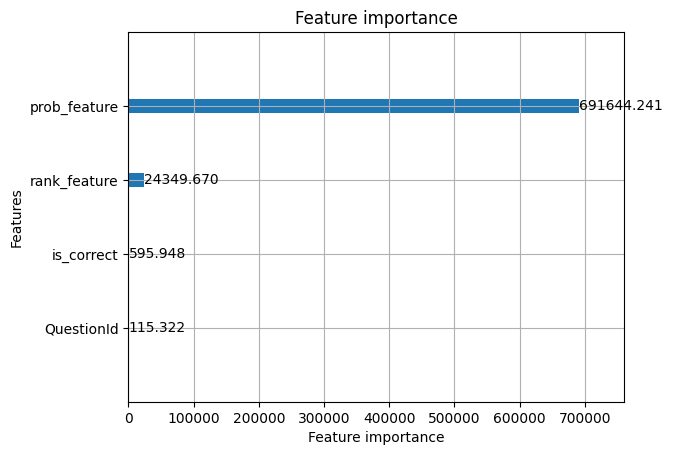

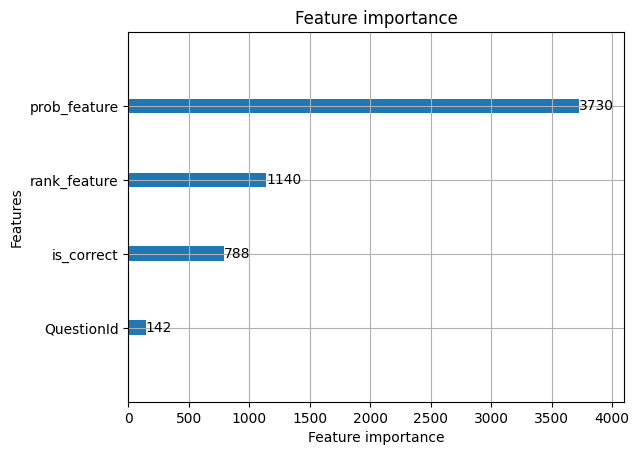

In [26]:
import matplotlib.pyplot as plt

# Gain-based importance (how much each feature contributes to splits)
lgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

# Split-based importance (how often a feature was used)
lgb.plot_importance(model, importance_type="split", max_num_features=20)
plt.show()


In [27]:
# Get model dump in text
text_dump = model.booster_.dump_model()
print(text_dump["tree_info"][0])  # first tree

# Save to JSON
import json
with open("lgbm_model.json", "w") as f:
    json.dump(text_dump, f, indent=2)


AttributeError: 'Booster' object has no attribute 'booster_'

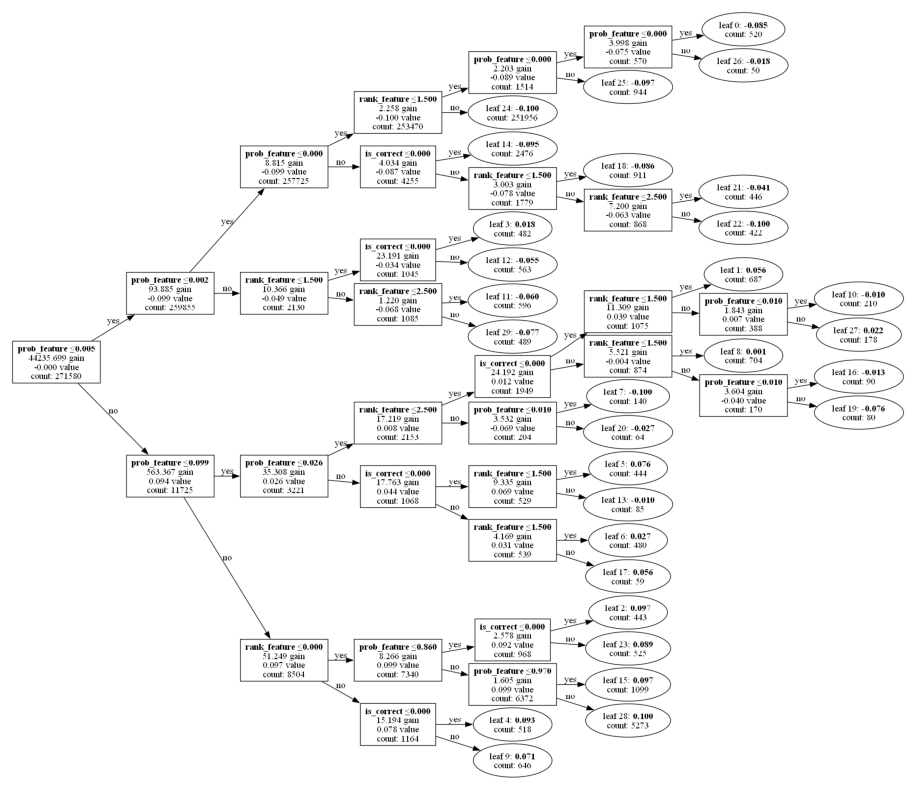

In [28]:
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()


In [94]:
import numpy as np
import pandas as pd
from functools import partial
from tqdm import tqdm

def apply_rank_adjustment(df, lam_dict, topk=None):
    """Apply per-class rank adjustment with given lam_dict"""
    val_df = df.copy()
    val_df["Pred_Targets_list"] = val_df["Pred_Targets"].str.split("|")
    val_df["Pred_Probs_list"] = val_df["Corresponding Probs"].str.split("|").apply(lambda x: [float(p) for p in x])

    def adjust_row(row):
        targets = row["Pred_Targets_list"]
        probs = row["Pred_Probs_list"]

        adj_probs = []
        for r, (t, p) in enumerate(zip(targets, probs)):
            # lam = lam_dict.get(t, 0.0)   # default 0 if not tuned
            # if r == 0:
            #     adj_probs.append(p)
            # elif r >= 5:
            #     adj_probs.append(p)
            # else:
            lam = lam_dict[t]
            adj_probs.append(p + lam / (r+1))

        order = np.argsort(-np.array(adj_probs))
        new_targets = [targets[i] for i in order]
        new_probs   = [probs[i] for i in order]

        if topk:
            new_targets = new_targets[:topk]
            new_probs   = new_probs[:topk]

        return pd.Series([new_targets, new_probs])

    val_df[["New_Pred_Targets_list", "New_Pred_Probs_list"]] = val_df.apply(adjust_row, axis=1)
    return val_df


def map3_score(y_true, y_pred):
    """Compute MAP@3"""
    total = 0.0
    for t, preds in zip(y_true, y_pred):
        if t == preds[0]:
            total += 1.0
        elif len(preds) > 1 and t == preds[1]:
            total += 1.0 / 2
        elif len(preds) > 2 and t == preds[2]:
            total += 1.0 / 3
    return total / len(y_true)


def objective(lam_dict, df, y_true, pred_col="Pred_Targets"):
    df_adj = apply_rank_adjustment(df, lam_dict)
    return map3_score(y_true, df_adj["New_Pred_Targets_list"].tolist())


def optimize_lambdas(df, classes=None, max_iters=50, init_val=0.1, step=0.1):
    """
    Simple coordinate descent to optimize per-class lambdas for MAP@3
    """
    if classes is None:
        classes = df["misconception_target"].unique().tolist()

    y_true = df["misconception_target"].tolist()

    # init all lambdas to same value
    lam_dict = {c: init_val for c in classes}
    best_score = objective(lam_dict, df, y_true)

    print(f"Initial MAP@3 = {best_score:.4f}")

    for it in range(max_iters):
        improved = False
        for c in classes:
            current = lam_dict[c]

            for delta in [-step, step]:
                # new_val = max(0, current + delta)
                # new_val = np.clip(current + delta, -1.0, 1.0)?
                new_val = current + delta
                trial_dict = lam_dict.copy()
                trial_dict[c] = new_val
                score = objective(trial_dict, df, y_true)
                if score > best_score:
                    best_score = score
                    lam_dict = trial_dict
                    improved = True
                    print(f"Iter {it} | Class {c} | λ={new_val:.3f} | MAP@3={score:.4f}")
        if not improved:
            break

    print(f"Final MAP@3 = {best_score:.4f}")
    return lam_dict, best_score


In [95]:
# Optimize λ per class
lam_dict, best_score = optimize_lambdas(val_df, max_iters=5, init_val=0, step=0.1)

# Apply to validation set
df_new = apply_rank_adjustment(val_df, lam_dict)
print(lam_dict)
print("MAP@3 after tuning:", map3_score(val_df["misconception_target"].tolist(),
                                       df_new["New_Pred_Targets_list"].tolist()))



Initial MAP@3 = 0.9464
Iter 0 | Class Misconception:WNB | λ=-0.100 | MAP@3=0.9465
Iter 0 | Class Misconception:SwapDividend | λ=-0.100 | MAP@3=0.9466
Iter 0 | Class Misconception:Denominator-only_change | λ=-0.100 | MAP@3=0.9467
Iter 0 | Class Misconception:Firstterm | λ=-0.100 | MAP@3=0.9467
Final MAP@3 = 0.9467
{'Neither:NA': 0, 'Correct:NA': 0, 'Misconception:Incomplete': 0, 'Misconception:WNB': -0.1, 'Misconception:SwapDividend': -0.1, 'Misconception:Mult': 0, 'Misconception:FlipChange': 0, 'Misconception:Irrelevant': 0, 'Misconception:Wrong_Fraction': 0, 'Misconception:Additive': 0, 'Misconception:Adding_terms': 0, 'Misconception:Not_variable': 0, 'Misconception:Inverse_operation': 0, 'Misconception:Duplication': 0, 'Misconception:Wrong_Operation': 0, 'Misconception:Inversion': 0, 'Misconception:Whole_numbers_larger': 0, 'Misconception:Ignores_zeroes': 0, 'Misconception:Longer_is_bigger': 0, 'Misconception:Shorter_is_bigger': 0, 'Misconception:Wrong_fraction': 0, 'Misconception:In

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

def plot_class_distributions(df_check, target_col="misconception_target"):
    """
    For each unique class in `target_col`:
        - Plot histogram of `rank_col` split by whether target == class
        - Plot histogram of `prob_col` split by whether target == class
    """
    class_counts = df_check[target_col].value_counts().sort_values(ascending=False)
    rank_col = "cls_rank"
    prob_col = "cls_prob"
    
    for cls_, count in class_counts[:3].items():
        def plot_histograms(tmp, cls_, count):
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # --- gt_rank histogram ---
            sns.histplot(data=tmp, x=rank_col, hue="is_cls", bins=37, multiple="stack", ax=axes[0])
            axes[0].set_title(f"{cls_} (freq={round(count/len(df_check),2)}) — GT Rank Distribution")
            axes[0].set_xlabel("Class Rank")
            axes[0].xaxis.set_minor_locator(MultipleLocator(1))

            # --- gt_prob histogram ---
            sns.histplot(data=tmp, x=prob_col, hue="is_cls", bins=50, multiple="stack", ax=axes[1])
            axes[1].set_title(f"{cls_} (freq={round(count/len(df_check),2)}) — GT Prob Distribution")
            axes[1].set_xlabel("Class Probability")
            axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))

            plt.tight_layout()
            plt.show()

        tmp = df_check.copy()
        tmp["is_cls"] = tmp[target_col] == cls_
        tmp["cls_rank"] = tmp.apply(lambda x: x["Pred_Targets_list"].index(cls_), axis=1)
        tmp["cls_prob"] = tmp.apply(lambda x: x["Pred_Probs_list"][x["cls_rank"]], axis=1)

        plot_histograms(tmp, cls_, count)


        def plot_prob_distributions_by_rank(tmp, cls_name, max_rank=3):
            """
            For each rank (0..max_rank), plot histogram of cls_prob split by is_cls
            """
            for r in range(max_rank+1):
                subset = tmp[tmp["cls_rank"] == r]
                if subset.empty:
                    continue

                plt.figure(figsize=(8, 4))
                sns.histplot(data=subset, x="cls_prob", hue="is_cls",
                            bins=30, multiple="stack", edgecolor="black")
                plt.title(f"{cls_name} — Probability Distribution at Rank={r} "
                        f"(n={len(subset)})")
                plt.xlabel("Class Probability")
                plt.ylabel("Proportion")
                plt.tight_layout()
                plt.show()
        plot_prob_distributions_by_rank(tmp, cls_, max_rank=3)
        # # Plot another plot. That for each unique cls_rank, (cls_rank as x-axis), plot violin plot of cls_prob hue by is_cls
        # plt.figure(figsize=(12, 6))
        # sns.violinplot(data=tmp[tmp["cls_rank"]<=3], x="cls_rank", y="cls_prob", hue="is_cls", split=True, inner="quart", palette="muted")
        # plt.title(f"{cls_} — GT Prob Violin Plot")
        # plt.xlabel("Class Rank")
        # plt.ylabel("Class Probability")
        # plt.show()


In [58]:
# val_df["Pred_Targets_list"].apply(lambda x: x.index("Correct:NA")).value_counts()

In [59]:
# val_df[ (val_df["misconception_target"]!="Correct:NA") & (val_df["Pred_Targets_list"].apply(lambda x: x[0]=="Correct:NA")) ]["misconception_target"].value_counts()

In [60]:
# cls = "Neither:NA"
# val_df[f"{cls}_rank"] = val_df.apply(lambda x: x["Pred_Targets_list"].index(cls), axis=1)
# val_df[f"{cls}_prob"] = val_df.apply(lambda x: x["Pred_Probs_list"][x[f"{cls}_rank"]], axis=1)

# val_df[ (val_df["misconception_target"]!="Correct:NA") & (val_df["Pred_Targets_list"].apply(lambda x: x[1]=="Correct:NA")) ]["misconception_target"].value_counts()

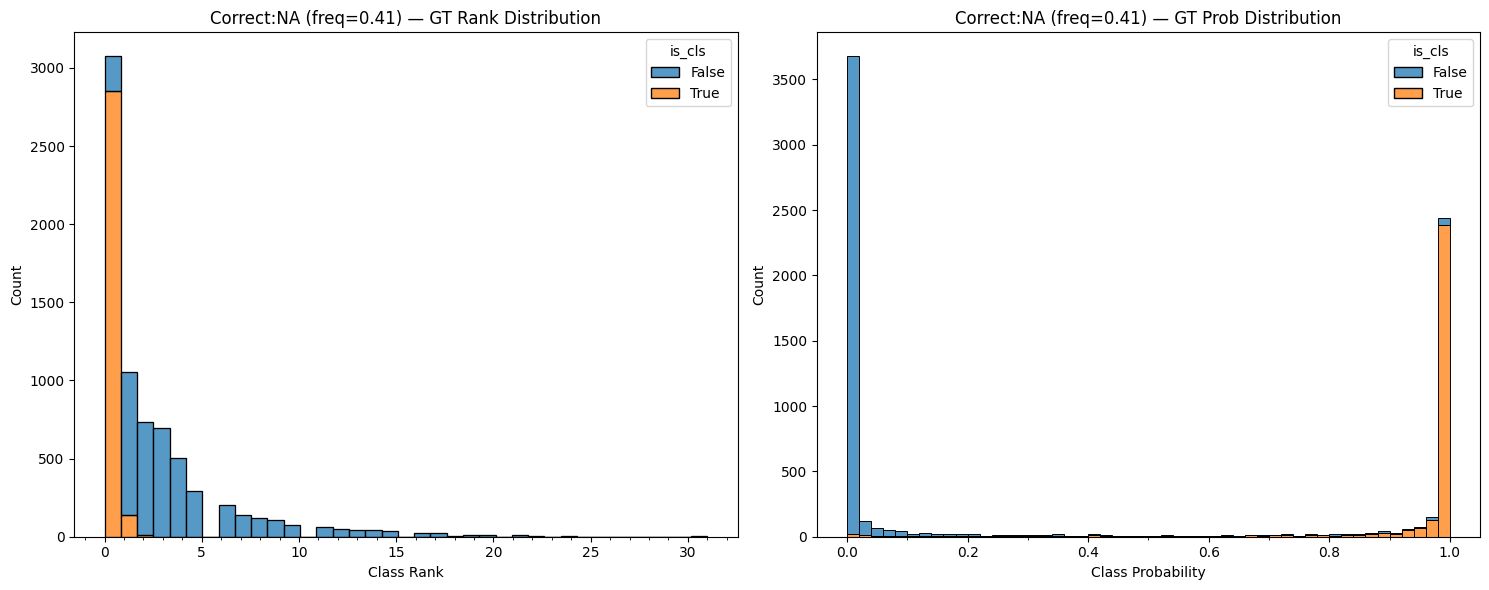

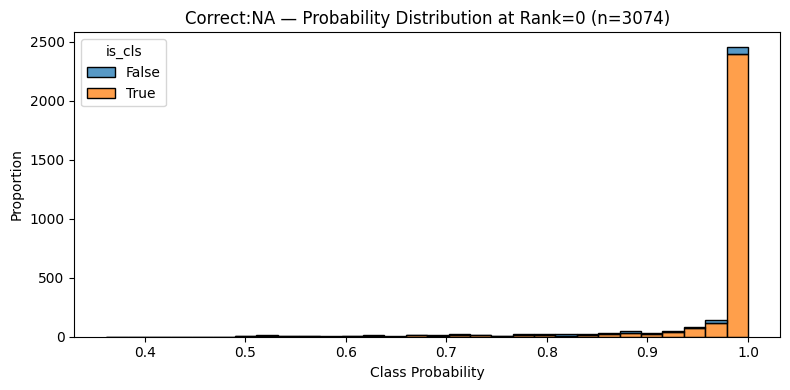

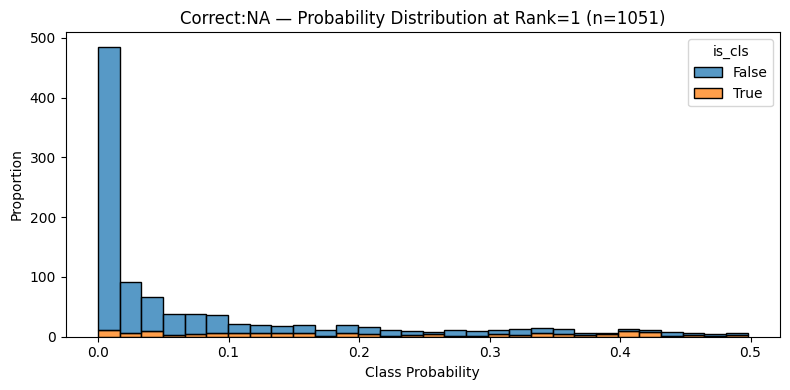

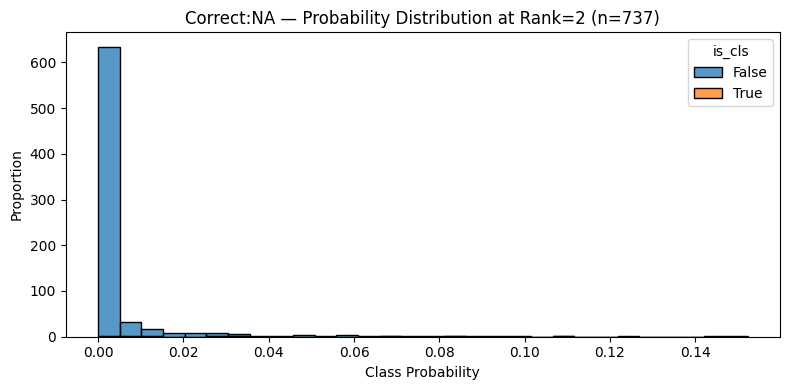

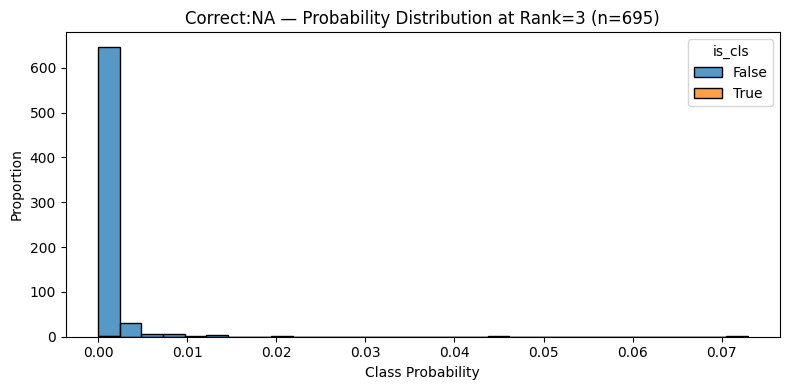

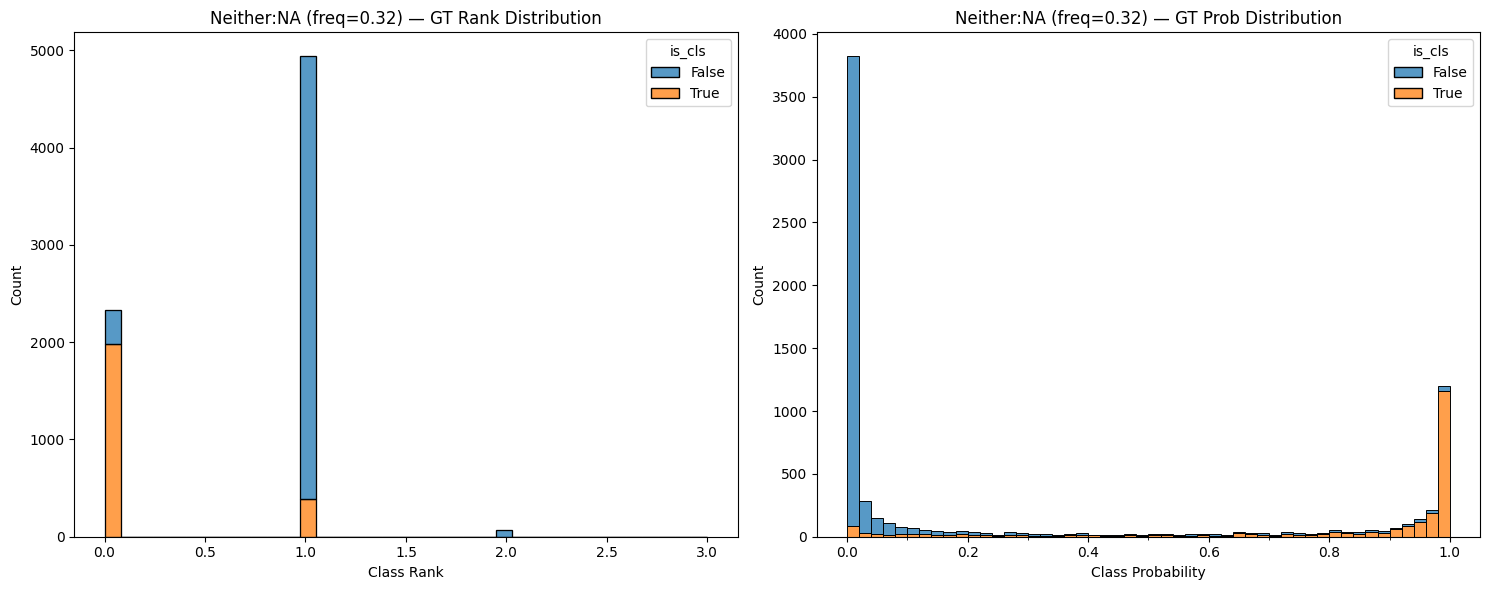

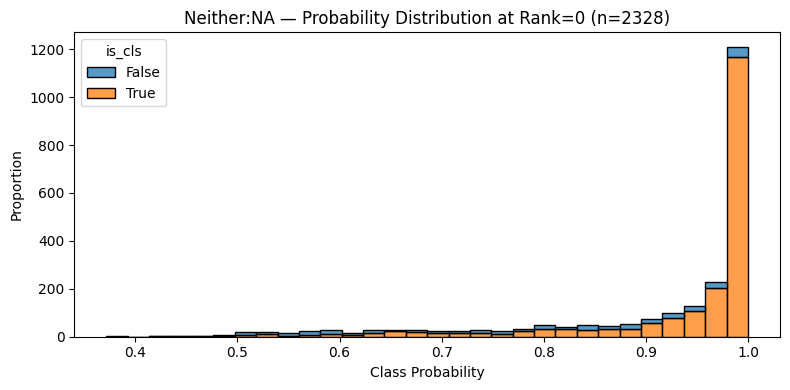

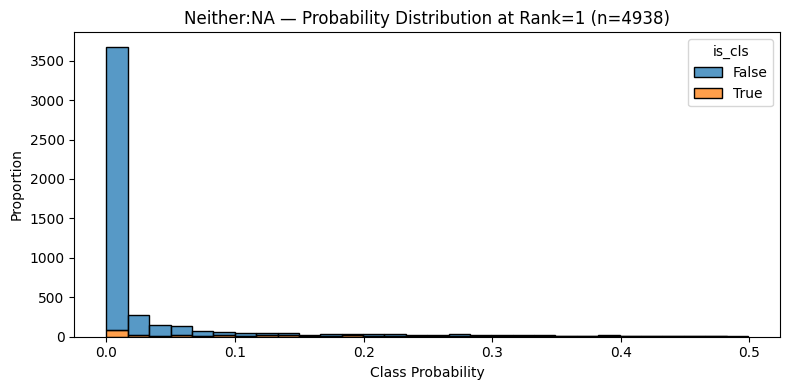

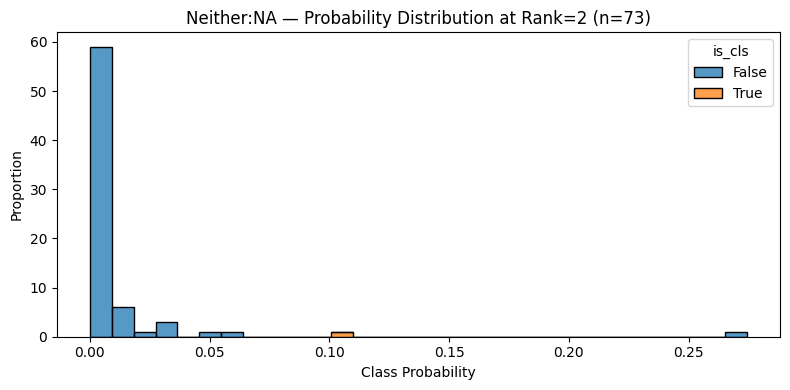

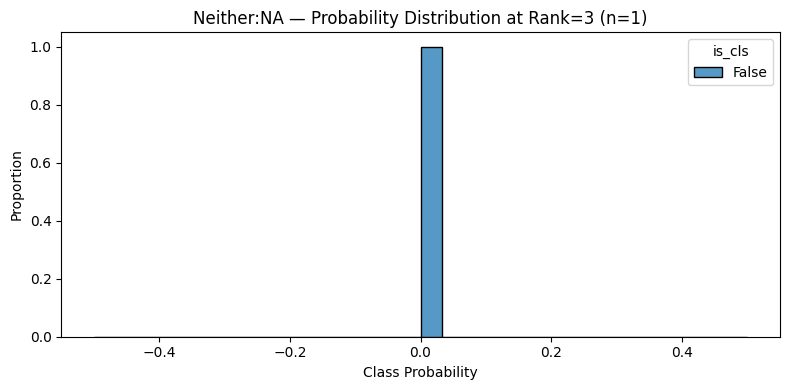

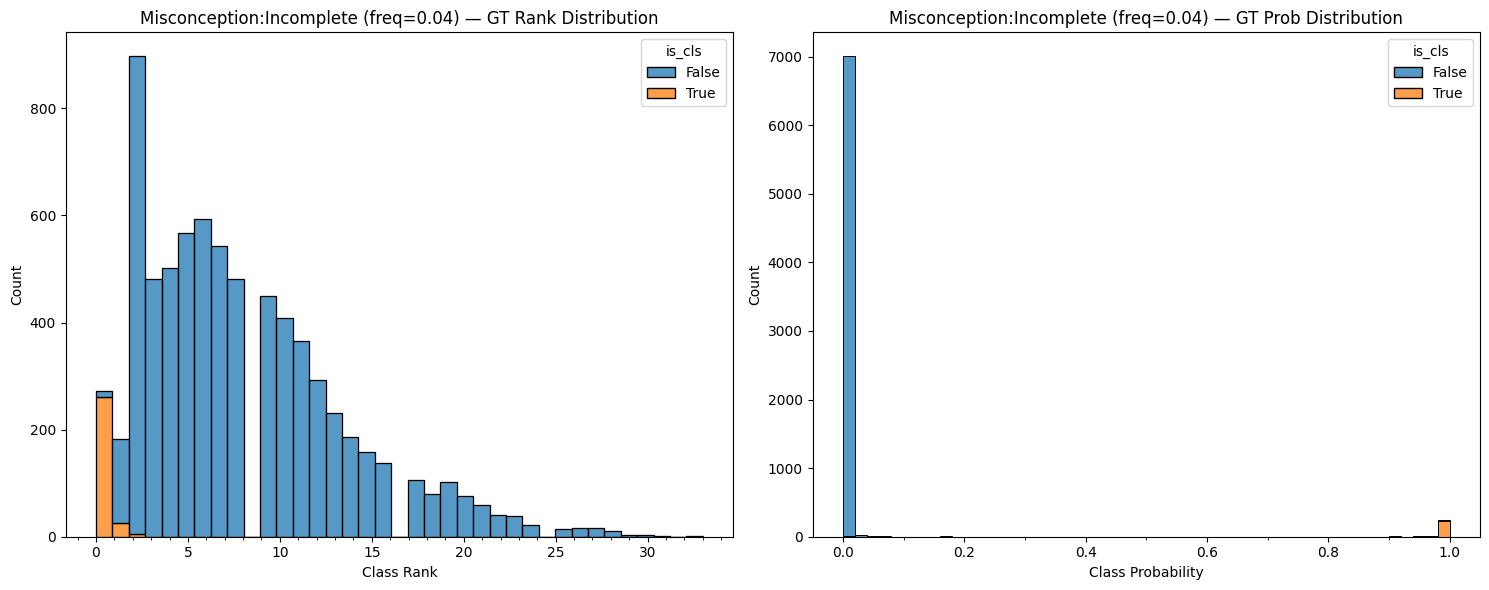

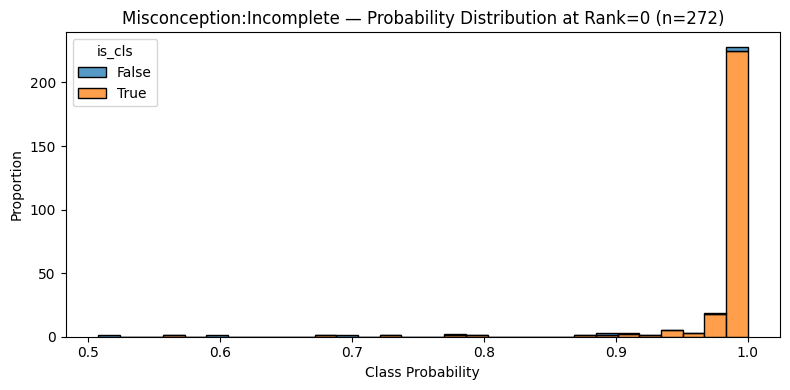

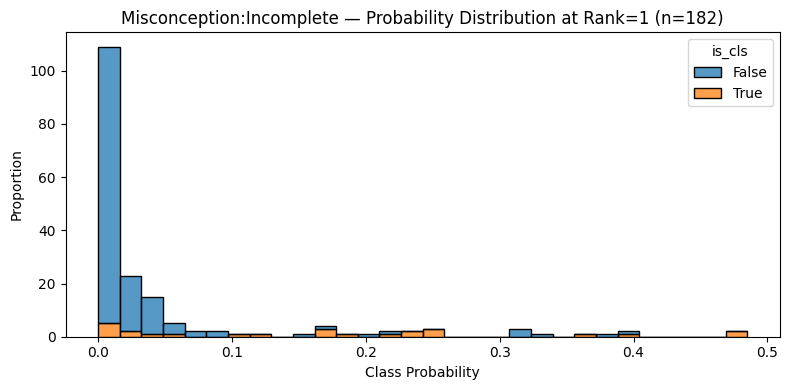

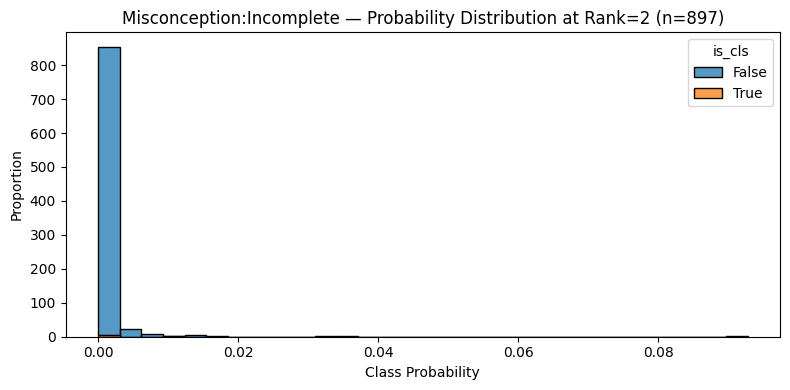

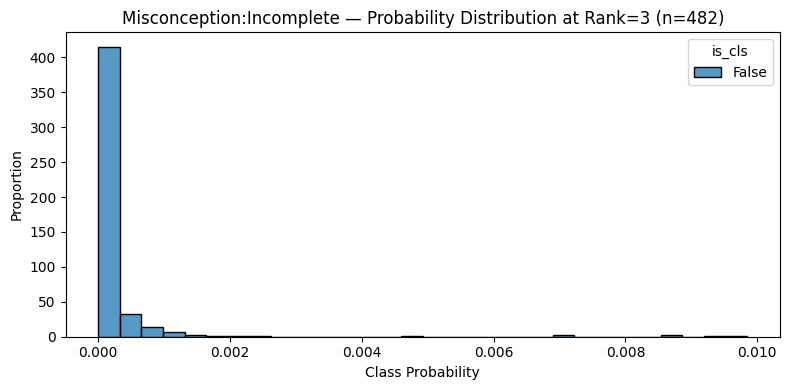

In [61]:
plot_class_distributions(val_df)

misconception_target
Correct:NA                                              3004
Neither:NA                                              2360
Misconception:Incomplete                                 291
Misconception:Additive                                   186
Misconception:Duplication                                141
Misconception:Subtraction                                124
Misconception:Positive                                   113
Misconception:Wrong_term                                 111
Misconception:Irrelevant                                  99
Misconception:Wrong_fraction                              84
Misconception:Inversion                                   83
Misconception:Mult                                        70
Misconception:Denominator-only_change                     67
Misconception:Whole_numbers_larger                        66
Misconception:Adding_across                               62
Misconception:WNB                                         61
Mis

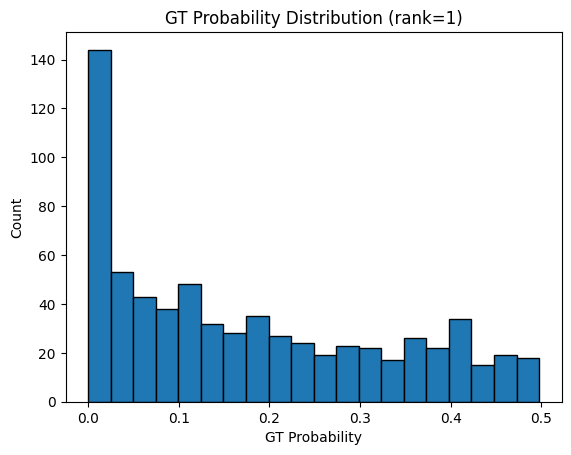


===== Ground Truth Rank = 2 =====
Top Ground Truth Labels:
misconception_target
Correct:NA                        12
Misconception:Irrelevant           8
Misconception:Incomplete           5
Misconception:Tacking              5
Misconception:SwapDividend         4
Misconception:Wrong_fraction       4
Misconception:FlipChange           4
Misconception:Multiplying_by_4     2
Misconception:Additive             2
Misconception:Adding_terms         2
Name: count, dtype: int64

Ground Truth Probability Summary:
count    63.000000
mean      0.039670
std       0.063677
min       0.000079
25%       0.002867
50%       0.011474
75%       0.039854
max       0.283877
Name: gt_prob, dtype: float64


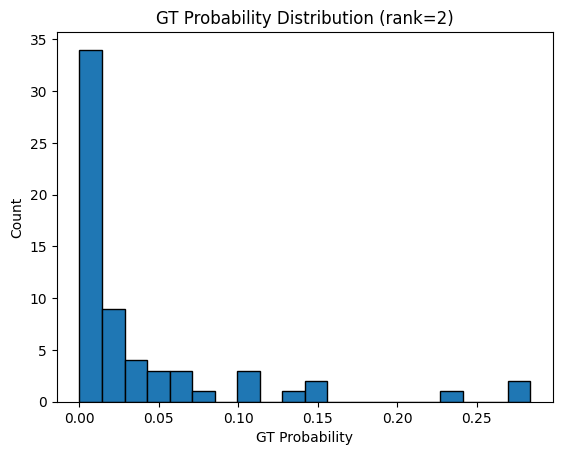


===== Ground Truth Rank = 3 =====
Top Ground Truth Labels:
misconception_target
Misconception:FlipChange              3
Correct:NA                            1
Misconception:Wrong_Operation         1
Misconception:Whole_numbers_larger    1
Name: count, dtype: int64

Ground Truth Probability Summary:
count    6.000000
mean     0.005446
std      0.006455
min      0.000326
25%      0.000906
50%      0.002238
75%      0.010485
max      0.014178
Name: gt_prob, dtype: float64


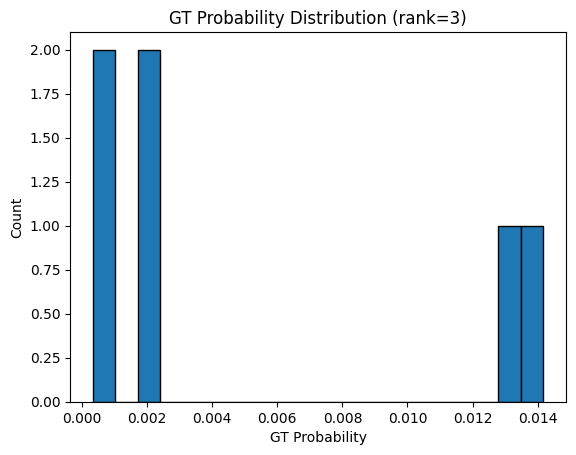


===== Ground Truth Rank = 4 =====
Top Ground Truth Labels:
misconception_target
Misconception:Ignores_zeroes       1
Misconception:Shorter_is_bigger    1
Name: count, dtype: int64

Ground Truth Probability Summary:
count    2.000000
mean     0.002123
std      0.000831
min      0.001536
25%      0.001830
50%      0.002123
75%      0.002417
max      0.002711
Name: gt_prob, dtype: float64


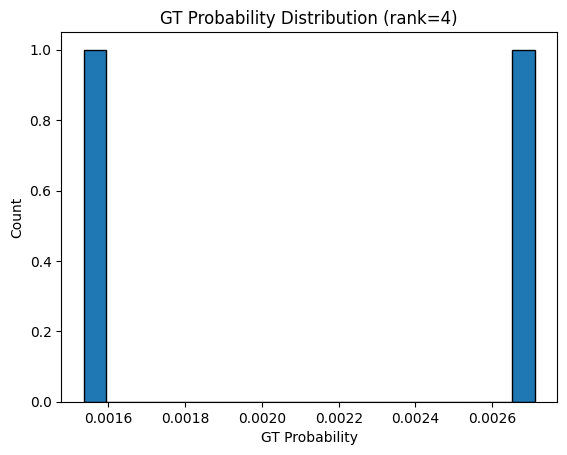

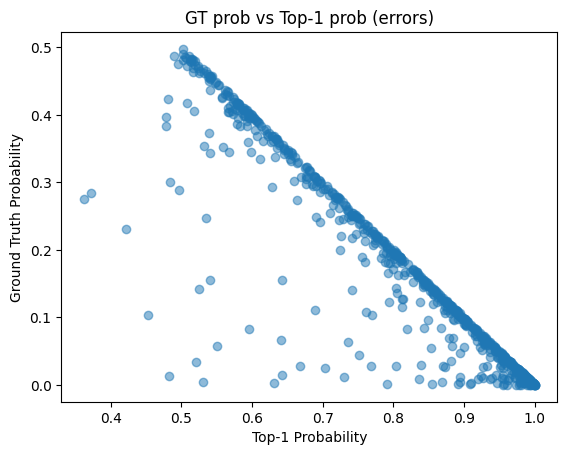

In [6]:
import matplotlib.pyplot as plt

print(val_df["misconception_target"].value_counts().head(37))

# Filter only the non-perfect cases
mistakes = val_df[val_df["map_score"] != 1].copy()

# Group by gt_rank
for rank, group in mistakes.groupby("gt_rank"):
    print(f"\n===== Ground Truth Rank = {rank} =====")

    # Distribution of ground truth labels
    print("Top Ground Truth Labels:")
    print(group["misconception_target"].value_counts().head(10))

    # Probability summary
    print("\nGround Truth Probability Summary:")
    print(group["gt_prob"].describe())

    # Plot histogram of probs for this rank
    plt.hist(group["gt_prob"].dropna(), bins=20, edgecolor="black")
    plt.title(f"GT Probability Distribution (rank={rank})")
    plt.xlabel("GT Probability")
    plt.ylabel("Count")
    plt.show()


# If you want to see scatter between top1 prob and gt prob:
mistakes["top1_prob"] = mistakes["Pred_Probs_list"].apply(lambda x: x[0])
plt.scatter(mistakes["top1_prob"], mistakes["gt_prob"], alpha=0.5)
plt.xlabel("Top-1 Probability")
plt.ylabel("Ground Truth Probability")
plt.title("GT prob vs Top-1 prob (errors)")
plt.show()
